# Reforumlated Markowitz Model - Optimization Codes through Quantum Computing

Import the necessary libraries

In [54]:
import numpy as np
import pandas as pd
from dimod import ConstrainedQuadraticModel, Integer, Binary
import time
from matplotlib import pyplot as plt
import math
import seaborn as sns

Importing the Data

In [2]:
df = pd.read_excel("Daily_Returns.xlsx")

Changing the Date to the index

In [3]:
# Convert the 'date' column to datetime format 
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'date' column as the index
df.set_index('Date', inplace=True)

Calculating the expected returns and the variance covariance matrix

In [4]:
# Calculate expected returns for each asset
expected_returns = np.mean(df,axis=0)*252

# Calculate the variance-covariance matrix
cov_matrix = df.cov()


#Converting the expected returns to a numpy array
expected_returns = expected_returns.values

#The number of assets
n_assets = len(expected_returns)

Setting the values of the constraints

In [106]:
# Maximum acceptable risk (R): The total risk that the portfolio can assume, based on variance-covariance matrix
R = 0.1

# Maximum units of each asset that can be purchased (D)
D = 5

# Maximum number of assets in the portfolio (K): The maximum number of different assets that can be included in the portfolio
K = 15

# The number of shares the investor would like to purchase
S = 20

# Setting the value for the number of binary variables required to represent a single decision variable
M = math.floor(math.log2(S)) +1

Creating the Decision Variables

In [7]:
y = [Binary(f"y_{i}") for i in range(n_assets)] #To represent y

In [107]:
Z =  [[Binary(f"z_{i}_{l}") for l in range(M)] for i in range(n_assets)] #To represent x
# Calculate X as the weighted sum of Z's components
X = [sum(2**j * Z[i][j] for j in range(M)) for i in range(n_assets)]

# X = [Integer(f"x_{i}") for i in range(n_assets)] #To represent x

Finding the weights

In [108]:
W = [x/S for x in X] 

Create the CQM Object

In [109]:
cqm = ConstrainedQuadraticModel()

Creating the Objective Function

In [110]:
H_obj = 0
for i in range(n_assets):
    H_obj -= expected_returns[i] * W[i]

Creating the risk constraint

In [111]:
# Convert the Variance Covariance matrix to a NumPy array
cov_matrix_np = cov_matrix.to_numpy()

# Convert X to a NumPy array
W_numeric = np.array(W)  

# Calculate the total variance
total_variance = np.dot(W_numeric.T, np.dot(cov_matrix_np, W_numeric))

Setting the Objective Function

In [112]:
cqm.set_objective(H_obj)

Setting the Risk Constraint

In [113]:
cqm.add_constraint_from_model(total_variance, '<=', R**2, "Variance", weight=1)

'Variance'

Adding the Linking Constraints

In [114]:
# Diversification Constraints
for i in range(n_assets):
    cqm.add_constraint_from_model(X[i] - D*y[i], '<=', 0, label=f"Linking_{i}", weight=1)

Adding the cardinality constraint

In [115]:
cqm.add_constraint_from_model(sum(y), '<=', K, label="Cardinality", weight=1)

'Cardinality'

Adding the constraint on the number of shares

In [116]:
cqm.add_constraint_from_model(sum(X), '==', S, label="Total Shares", weight=1)

'Total Shares'

Solving the optimization problem

In [5]:
from dwave.system import LeapHybridCQMSampler
sampler = LeapHybridCQMSampler(token="DEV-df309da97162b976954c423a5c0df694bc7b7bdf")  

In [118]:
#Solve the problem
sampleset = sampler.sample_cqm(cqm)

In [119]:
print(sampleset.first) 

Sample(sample={'y_0': 0.0, 'y_1': 0.0, 'y_10': 0.0, 'y_100': 0.0, 'y_101': 0.0, 'y_102': 0.0, 'y_103': 0.0, 'y_104': 0.0, 'y_105': 0.0, 'y_106': 0.0, 'y_107': 0.0, 'y_108': 0.0, 'y_109': 0.0, 'y_11': 0.0, 'y_110': 0.0, 'y_111': 0.0, 'y_112': 0.0, 'y_113': 0.0, 'y_114': 0.0, 'y_115': 0.0, 'y_116': 0.0, 'y_117': 0.0, 'y_118': 0.0, 'y_119': 0.0, 'y_12': 0.0, 'y_120': 0.0, 'y_121': 0.0, 'y_122': 1.0, 'y_123': 0.0, 'y_124': 0.0, 'y_125': 0.0, 'y_126': 0.0, 'y_127': 0.0, 'y_128': 0.0, 'y_129': 0.0, 'y_13': 0.0, 'y_130': 1.0, 'y_131': 0.0, 'y_132': 0.0, 'y_133': 0.0, 'y_134': 0.0, 'y_135': 0.0, 'y_136': 0.0, 'y_137': 0.0, 'y_138': 1.0, 'y_139': 0.0, 'y_14': 0.0, 'y_140': 0.0, 'y_141': 0.0, 'y_142': 0.0, 'y_143': 0.0, 'y_144': 0.0, 'y_15': 0.0, 'y_16': 0.0, 'y_17': 0.0, 'y_18': 0.0, 'y_19': 0.0, 'y_2': 0.0, 'y_20': 0.0, 'y_21': 0.0, 'y_22': 0.0, 'y_23': 0.0, 'y_24': 0.0, 'y_25': 0.0, 'y_26': 0.0, 'y_27': 0.0, 'y_28': 0.0, 'y_29': 0.0, 'y_3': 0.0, 'y_30': 0.0, 'y_31': 0.0, 'y_32': 0.0, 'y_33': 

Checking for the violation of constraints

In [120]:
for label, violation in cqm.iter_violations(sampleset.first[0], skip_satisfied=True):
    print(label, violation)

Recreating the original decision variables

In [122]:
sample = sampleset.first[0]


# Number of decision variables
num_decision_variables = n_assets

# Reconstruct the original decision variables
decision_variables = []
for i in range(num_decision_variables):
    value = 0
    for j in range(M): 
        bit_value = sample[f'z_{i}_{j}']
        value += 2**j * bit_value
    decision_variables.append(value)

decision_variables

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 0.0,
 3.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 5.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [124]:
# sample = sampleset.first[0]

# # Number of decision variables
# num_decision_variables = n_assets

# # Reconstruct the original decision variables
# decision_variables = []
# for i in range(num_decision_variables):
#     decision_variables.append(sample[f'x_{i}'])

# decision_variables


Calculating the Return

In [125]:
# Find the weights
result = [x / S for x in decision_variables]


# Multiply corresponding elements and sum them up
total = sum(x * y for x, y in zip(expected_returns, result))

print(total)

0.2986056225531332


Now let us test to see if all the constraints are satisfied

In [126]:
# Extract y values from sample
y_optimized = np.array([sample[f'y_{i}'] for i in range(n_assets)])

# Convert decision_variables to a numpy array for easy manipulation
x_optimized = np.array(decision_variables)
w_optimized = np.array(result)

# Now, checking the constraints with these values
# Constraint 1: Risk constraint
risk_value = np.sqrt(np.dot(np.dot(w_optimized.T, cov_matrix), w_optimized))
print(f"Risk Constraint Satisfied: {risk_value <= R}")
print(f"Risk Value: {risk_value} <= {R}")

# Constraint 2: Linking constraint
diversification_values = x_optimized <= D * y_optimized
print(f"Linking Constraints Satisfied: {all(diversification_values)}")

# Constraint 3: Cardinality constraint
cardinality_value = (x_optimized > 0).sum()
print(f"Cardinality Constraint Satisfied: {cardinality_value <= K}")
print(f"Number of Assets Included: {cardinality_value} <= {K}")

# Constraint 4: Non-negativity constraint
non_negativity_satisfied = all(x_optimized >= 0)
print(f"Non-negativity Constraints Satisfied: {non_negativity_satisfied}")


# Constraint 5: Sum of units
unit_sum = sum(x_optimized)
print(f"Sum of units Constraint Satisfied: {unit_sum <= S}")
print(f"Number of units Included: {unit_sum} <= {S}")


Risk Constraint Satisfied: True
Risk Value: 0.01756241650464456 <= 0.1
Linking Constraints Satisfied: True
Cardinality Constraint Satisfied: True
Number of Assets Included: 6 <= 15
Non-negativity Constraints Satisfied: True
Sum of units Constraint Satisfied: True
Number of units Included: 20.0 <= 20


Checking the assets to invest in

In [127]:
values_list = x_optimized.tolist()

# Creating a new DataFrame with column names and values where values are > 0
filtered_data = {'Asset': [], 'Value': []}
for column_name, value in zip(df.columns, values_list):
    if value > 0:
        filtered_data['Asset'].append(column_name)
        filtered_data['Value'].append(value)

new_df = pd.DataFrame(filtered_data)

print(new_df)

  Asset  Value
0  BKNG    3.0
1   CMI    3.0
2   CNC    3.0
3   KMX    3.0
4  NFLX    5.0
5  TSLA    3.0


Calculating the portfolio with the highest returns

In [6]:
#Sum of shares
S = 1000

M = math.floor(math.log2(S)) +1

Z =  [[Binary(f"z_{i}_{l}") for l in range(M)] for i in range(n_assets)] #To represent x
# Calculate X as the weighted sum of Z's components
X = [sum(2**j * Z[i][j] for j in range(M)) for i in range(n_assets)]

# X = [Integer(f"x_{i}") for i in range(n_assets)] #To represent x
W = [x/S for x in X] #For the weight

H_obj = 0
for i in range(n_assets):
    H_obj -= expected_returns[i] * W[i]

# Create the CQM Object
cqm = ConstrainedQuadraticModel()

#Adding the objective function
cqm.set_objective(H_obj)


#Adding the sum of shares constraint
cqm.add_constraint_from_model(sum(X), '==', S, label="Total Shares", weight=5)

#Solve the problem
sampleset = sampler.sample_cqm(cqm)

#Checking for violations
for label, violation in cqm.iter_violations(sampleset.first[0], skip_satisfied=True):
    print(label, violation)


#Recreating the decision variables
sample = sampleset.first[0]


# Number of decision variables
num_decision_variables = n_assets

# Reconstruct the original decision variables
decision_variables = []
for i in range(num_decision_variables):
    value = 0
    for j in range(M): 
        bit_value = sample[f'z_{i}_{j}']
        value += 2**j * bit_value
    decision_variables.append(value)

decision_variables

# #Recreating the original variables
# sample = sampleset.first[0]

# # Number of decision variables
# num_decision_variables = n_assets

# # Reconstruct the original decision variables
# decision_variables = []
# for i in range(num_decision_variables):
#     decision_variables.append(sample[f'x_{i}'])

#Calculating the total return

# Find the weights
weights = [x / S for x in decision_variables]

# Multiply corresponding elements and sum them up
total = sum(x * y for x, y in zip(expected_returns, weights))

# Convert decision_variables to a numpy array for easy manipulation
x_optimized_max_return = np.array(decision_variables)

# Convert weights to a numpy array for easy manipulation
w_optimized_max_return = np.array(weights)

# Risk Value
risk_value_maximum_return = np.sqrt(np.dot(np.dot(w_optimized_max_return.T, cov_matrix), w_optimized_max_return))

print("The number of units to buy: ")
print(x_optimized_max_return)
print("SUM OF WEIGHTS:",sum(w_optimized_max_return))
print("Risk: ", risk_value_maximum_return)
print("Return: ", total)

The number of units to buy: 
[ 0. 14.  0.  7. 27. 10.  7.  2. 11.  6.  0.  9.  4.  7.  6. 18. 15.  0.
  1.  0. 20. 13.  0.  1. 11.  2. 55.  1.  5.  2.  6.  0.  2.  0.  3. 15.
  2.  7.  6.  3.  2.  0.  2.  4.  3. 29. 15.  0. 29.  2. 15.  0.  0.  0.
  0.  3.  3.  2.  0.  0.  8.  1.  2.  7.  1.  0. 14.  0. 12. 31.  0.  2.
  3.  0.  6.  6.  0.  0.  0.  2. 15. 15. 11.  0. 23.  2.  4. 11. 15.  2.
  0.  0.  7.  0. 15. 13. 63.  0.  1.  1.  3.  7.  0.  0. 27.  6.  2.  6.
  4. 15. 31.  0.  7.  0.  2.  0. 22.  3.  2.  0.  0.  1.  7.  0. 11.  4.
  5.  7.  0.  1. 63.  0.  0.  0.  2.  1. 14.  0. 31. 15.  1.  0.  0.  0.
  0.]
SUM OF WEIGHTS: 1.0000000000000007
Risk:  0.013268826338851937
Return:  0.22702441036005433


Calculating the portolio with the lowest risk

In [7]:
#Sum of shares
S = 1000

M = math.floor(math.log2(S)) +1

Z =  [[Binary(f"z_{i}_{l}") for l in range(M)] for i in range(n_assets)] #To represent x
# Calculate X as the weighted sum of Z's components
X = [sum(2**j * Z[i][j] for j in range(M)) for i in range(n_assets)]


# X = [Integer(f"x_{i}") for i in range(n_assets)] #To represent x
W = [x/S for x in X] #For the weight


# Convert the Variance Covariance matrix to a NumPy array
cov_matrix_np = cov_matrix.to_numpy()

# Convert X to a NumPy array
W_numeric = np.array(W)  

# Calculate the total variance
total_variance = np.dot(W_numeric.T, np.dot(cov_matrix_np, W_numeric))

# Create the CQM Object
cqm = ConstrainedQuadraticModel()

#Adding the objective function
cqm.set_objective(total_variance)


#Adding the sum of shares constraint
cqm.add_constraint_from_model(sum(X), '==', S, label="Total Shares", weight=1)

#Solve the problem
sampleset = sampler.sample_cqm(cqm)



#Checking for violations
for label, violation in cqm.iter_violations(sampleset.first[0], skip_satisfied=True):
    print(label, violation)



#Recreating the decision variables
sample = sampleset.first[0]


# Number of decision variables
num_decision_variables = n_assets

# Reconstruct the original decision variables
decision_variables = []
for i in range(num_decision_variables):
    value = 0
    for j in range(M): 
        bit_value = sample[f'z_{i}_{j}']
        value += 2**j * bit_value
    decision_variables.append(value)



# #Recreating the original variables
# sample = sampleset.first[0]

# # Number of decision variables
# num_decision_variables = n_assets

# # Reconstruct the original decision variables
# decision_variables = []
# for i in range(num_decision_variables):
#     decision_variables.append(sample[f'x_{i}'])




#Calculating the total return

# Find the weights
weights = [x / S for x in decision_variables]


# Multiply corresponding elements and sum them up
total = sum(x * y for x, y in zip(expected_returns, weights))

# Convert decision_variables to a numpy array for easy manipulation
x_optimized_MIN_RISK = np.array(decision_variables)

# Convert weights to a numpy array for easy manipulation
w_optimized_MIN_RISK = np.array(weights)

# Risk Value
risk_value_minimum = np.sqrt(np.dot(np.dot(w_optimized_MIN_RISK.T, cov_matrix), w_optimized_MIN_RISK))


print("The number of units to buy: ")
print(x_optimized_MIN_RISK)
print("SUM OF WEIGHTS:",sum(w_optimized_MIN_RISK))
print("Risk: ", risk_value_minimum)
print("Return: ", total)

The number of units to buy: 
[ 0.  2. 31.  1.  0.  1.  5.  1.  0.  0.  0.  0.  2.  7.  0.  0.  0.  0.
  1. 31.  0.  0.  7.  1.  5. 23.  0.  6.  0.  0.  0.  6.  0. 11.  0. 21.
  3.  0. 15.  0.  0.  7.  0. 15.  3.  0. 14.  0.  0.  0.  0.  7.  3. 15.
  1.  0.  0.  0. 47.  3.  0.  0. 31.  0.  7.  0.  0. 79.  0.  0. 31. 15.
  3. 31.  0.  0. 15. 23.  0.  1.  0.  4.  0. 14.  1.  3.  0.  5.  1.  7.
 15. 31.  0.  1.  0.  0.  0. 31.  2.  2.  0.  0.  0. 31.  0.  3.  0.  3.
 10.  0.  6.  0.  1. 31. 31.  0.  4. 11.  0.  0. 23.  0.  0. 23.  3.  7.
 31. 27. 25.  1.  2.  0. 15.  1. 15.  0.  7.  3.  7.  2.  5. 15.  7.  0.
  2.]
SUM OF WEIGHTS: 1.0000000000000004
Risk:  0.007518111215784708
Return:  0.12066535625572247


Calculating the efficient frontier

In [40]:
# Initialize arrays to store portfolio returns, volatilities, and weights
num_ports = 50

# Calculate the gap between portfolio volatilities for equally spaced portfolios
vol_min = risk_value_minimum
vol_max = risk_value_maximum_return
gap = (vol_max - vol_min) / (num_ports)

# Maximum acceptable risk (R): The total risk that the portfolio can assume, based on variance-covariance matrix
Variance_Values = [(vol_min + gap*i) for i in range(num_ports)]

In [41]:
"""

We will now loop over multiple risk values to calculate the return and get an efficient frontier and generate
each of the portfolios for these risk values. Note that all the constraints except the number of shares and the investor should invest
in and the risk value would be relaxed in this solution for the purpose of comparing with the vanilla markowitz model.

"""

#Sum of shares
S = 1000

M = math.floor(math.log2(S)) +1

results_list = []  # Initialize the list

for R in Variance_Values:

    Z =  [[Binary(f"z_{i}_{l}") for l in range(M)] for i in range(n_assets)] #To represent x
    # Calculate X as the weighted sum of Z's components
    X = [sum(2**j * Z[i][j] for j in range(M)) for i in range(n_assets)]


    # X = [Integer(f"x_{i}") for i in range(n_assets)] #To represent x
    W = [x/S for x in X] #For the weight

    # Check the variance value
    print(R)

    #Getting the objective function
    
    H_obj = 0
    for i in range(n_assets):
        H_obj -= expected_returns[i] * W[i]

    #Getting the risk
    
    # Convert the Variance Covariance matrix to a NumPy array
    cov_matrix_np = cov_matrix.to_numpy()

    # Convert X to a NumPy array
    W_numeric = np.array(W)  

    # Calculate the total variance
    total_variance = np.dot(W_numeric.T, np.dot(cov_matrix_np, W_numeric))

    # Create the CQM Object
    cqm = ConstrainedQuadraticModel()

    #Adding the objective function
    cqm.set_objective(H_obj)


    # Add risk constraints
    cqm.add_constraint_from_model(total_variance, '<=' ,(R)**2, label="Max Risk",weight=5)

    
    #Adding the sum of shares constraint
    cqm.add_constraint_from_model(sum(X), '==', S, label="Total Shares", weight=1)


    # Retrieve the last total return if available and add a non-decreasing return constraint
    if results_list:
        last_total = results_list[-1]['total_return']
        current_total = sum(expected_returns[i] * W[i] for i in range(n_assets))
        cqm.add_constraint(current_total, '>=', last_total, label="Non-decreasing Return", weight = 5)

    # Time the sampler
    start_time = time.time()
    sampleset = sampler.sample_cqm(cqm)
    time_taken = time.time() - start_time


    #Checking for violations
    for label, violation in cqm.iter_violations(sampleset.first[0], skip_satisfied=True):
        print(label, violation)


    # #Recreating the original variables
    # sample = sampleset.first[0]

    # # Number of decision variables
    # num_decision_variables = n_assets

    # # Reconstruct the original decision variables
    # decision_variables = []
    # for i in range(num_decision_variables):
    #     decision_variables.append(sample[f'x_{i}'])

    #Recreating the decision variables
    sample = sampleset.first[0]


    # Number of decision variables
    num_decision_variables = n_assets

    # Reconstruct the original decision variables
    decision_variables = []
    for i in range(num_decision_variables):
        value = 0
        for j in range(M): 
            bit_value = sample[f'z_{i}_{j}']
            value += 2**j * bit_value
        decision_variables.append(value)



    #Calculating the total return

    # Find the weights
    weights = [x / S for x in decision_variables]


    # Multiply corresponding elements and sum them up
    total = sum(x * y for x, y in zip(expected_returns, weights))

    # Convert decision_variables to a numpy array for easy manipulation
    x_optimized = np.array(decision_variables)

    # Convert weights to a numpy array for easy manipulation
    w_optimized = np.array(weights)

    # Constraint 1: Risk constraint
    risk_value = np.sqrt(np.dot(np.dot(w_optimized.T, cov_matrix), w_optimized))

    # Constraint 2: Non-negativity constraint
    non_negativity_satisfied = all(x_optimized >= 0)

    # Constraint 3: Sum of shares constraint
    sum_of_shares_satisfied = sum(x_optimized) == S

    #Creating the asset dataframe
    values_list = x_optimized.tolist()

    # Creating a new DataFrame with column names and values where values are > 0
    filtered_data = {'Asset': [], 'Value': []}
    for column_name, value in zip(df.columns, values_list):
        if value > 0:
            filtered_data['Asset'].append(column_name)
            filtered_data['Value'].append(value)

    # # Create a dictionary for the current iteration
    # iteration_results = {
    #     'time_taken': time_taken,
    #     'risk_value': risk_value,
    #     'R': R,
    #     'total_return': total,
    #     'risk_constraint_satisfied': risk_value <= R,
    #     'non_negativity_satisfied': non_negativity_satisfied,
    #     'Total_Shares_satisfied': sum_of_shares_satisfied,
    #     'assets_included_df': filtered_data
    # }


    #If the resulting return is lower than the previous iteration then store the value of the previous iteration,
    #else store the value of the new iteration
    # Check against the last total return
    if results_list:
        print("The return of the current iteration is:", total)
        print("The return of the previous iteration is:", results_list[-1]['total_return'])
        print("Current iteration value is greater than previous iteration:", total>results_list[-1]['total_return'])

    if results_list and total < results_list[-1]['total_return']:
        last_result = results_list[-1]
        iteration_results = {
            'time_taken': time.time() - start_time,  # Current iteration's time
            'R': R,  # Current risk level
            'risk_value': last_result['risk_value'],
            'total_return': last_result['total_return'],
            'risk_constraint_satisfied': last_result['risk_constraint_satisfied'],
            'non_negativity_satisfied': last_result['non_negativity_satisfied'],
            'Total_Shares_satisfied': last_result['Total_Shares_satisfied'],
            'assets_included_df': last_result['assets_included_df']
        }
    else:
        
        # Construct results for this iteration
        iteration_results = {
            'time_taken': time.time() - start_time,
            'risk_value': risk_value,
            'R': R,
            'total_return': total,
            'risk_constraint_satisfied': risk_value <= R,
            'non_negativity_satisfied': non_negativity_satisfied,
            'Total_Shares_satisfied': sum_of_shares_satisfied,
            'assets_included_df':  filtered_data
        }


    # Step 4: Append this dictionary to the list
    results_list.append(iteration_results)

0.007518111215784708
Max Risk 0.00012212524998357827
0.007633125518246052
Max Risk 0.00011930486668632027
Non-decreasing Return 0.010378794710296901
The return of the current iteration is: 0.2338298392033922
The return of the previous iteration is: 0.24420863391368922
Current iteration value is greater than previous iteration: False
0.007748139820707397
Max Risk 0.00012671317745624979
Non-decreasing Return 0.003642922142957833
The return of the current iteration is: 0.24056571177073133
The return of the previous iteration is: 0.24420863391368922
Current iteration value is greater than previous iteration: False
0.007863154123168742
Max Risk 0.00011733284909887016
The return of the current iteration is: 0.24775787065364885
The return of the previous iteration is: 0.24420863391368922
Current iteration value is greater than previous iteration: True
0.007978168425630086
Max Risk 0.00012113357506955074
Non-decreasing Return 0.009210737768717475
The return of the current iteration is: 0.23854

Creating a dataframe of results

In [42]:
# Creating a DataFrame from results_list for specific metrics
metrics_columns = [
    'time_taken',
    'risk_value',
    'R',
    'total_return',
    'risk_constraint_satisfied',
    'non_negativity_satisfied',
    'Total_Shares_satisfied'
]

# Use a list comprehension to pick out these specific keys from each dictionary in the results list
final_results_data = [{col: result[col] for col in metrics_columns} for result in results_list]

# Convert this list of dictionaries to a DataFrame
final_results_df = pd.DataFrame(final_results_data)

# Save the DataFrame as an Excel file
final_results_df.to_excel('Final_Results.xlsx', index=False)


Plotting the efficient frontier

In [43]:
#Calculating the sharpe ratio
final_results_df["Sharpe_Ratio"]=final_results_df["total_return"]/final_results_df["R"]

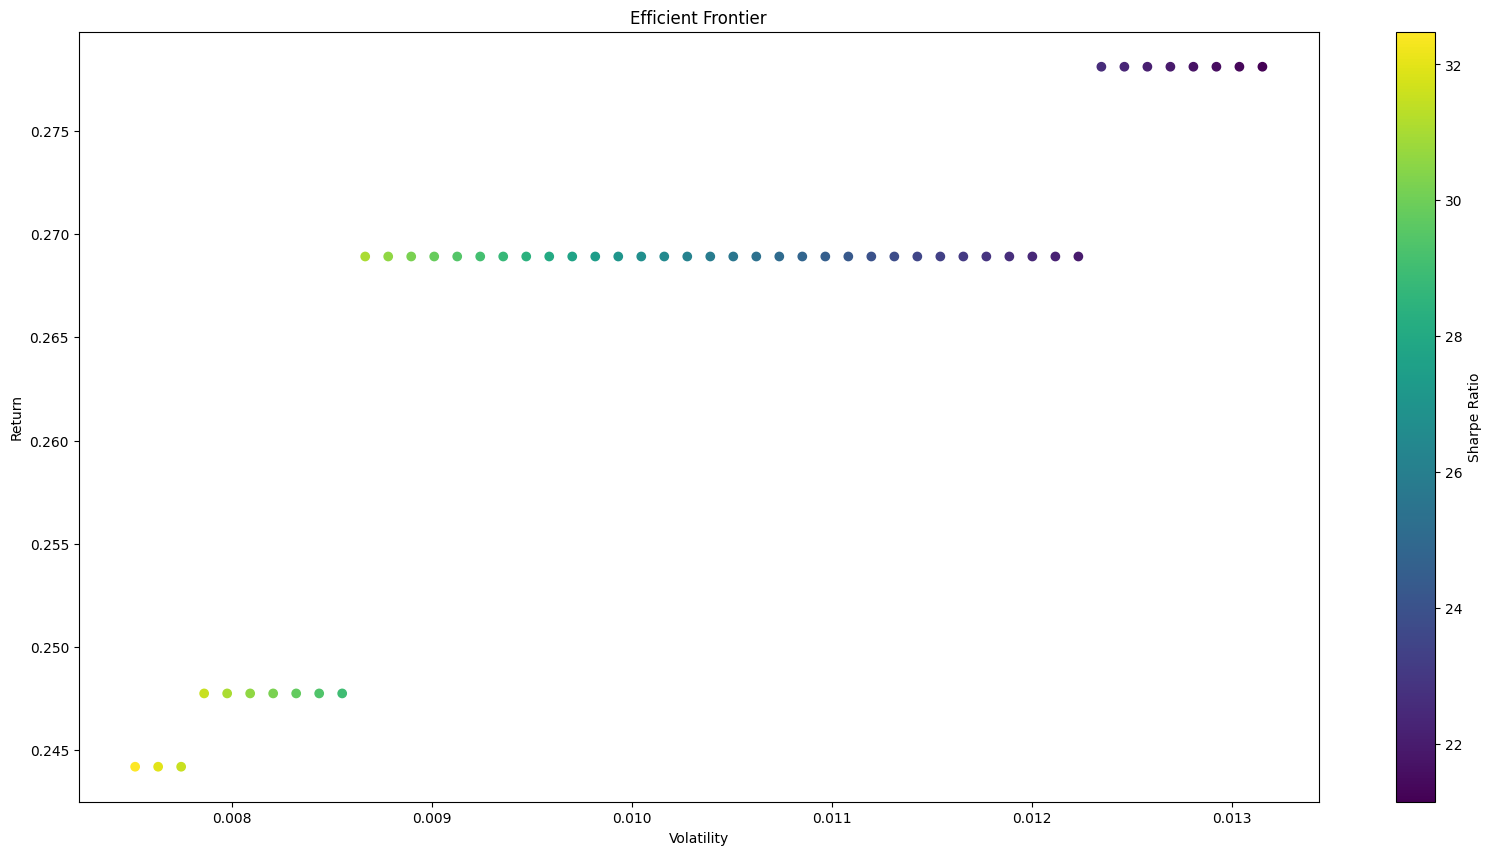

In [44]:

# Plotting the Efficient Frontier
plt.figure(figsize=(20, 10))
plt.scatter(final_results_df["R"], final_results_df["total_return"], c=final_results_df["Sharpe_Ratio"], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()


Creating the excels of Asset Allocations

In [46]:
for i, result in enumerate(results_list, start=1):
    # Convert filtered_data (which replaced new_df) to a DataFrame
    assets_df = pd.DataFrame(result['assets_included_df'])
    
    # Save the DataFrame as an Excel file
    file_name = f'Assets{i}.xlsx'
    assets_df.to_excel(file_name, index=False)

Creating the portfolio with risk 1%

In [50]:
#Sum of shares
S = 1000

M = math.floor(math.log2(S)) +1

Z =  [[Binary(f"z_{i}_{l}") for l in range(M)] for i in range(n_assets)] #To represent x
# Calculate X as the weighted sum of Z's components
X = [sum(2**j * Z[i][j] for j in range(M)) for i in range(n_assets)]

# X = [Integer(f"x_{i}") for i in range(n_assets)] #To represent x
W = [x/S for x in X] #For the weight

H_obj = 0
for i in range(n_assets):
    H_obj -= expected_returns[i] * W[i]

#Getting the risk

# Convert the Variance Covariance matrix to a NumPy array
cov_matrix_np = cov_matrix.to_numpy()

# Convert X to a NumPy array
W_numeric = np.array(W)  

# Calculate the total variance
total_variance = np.dot(W_numeric.T, np.dot(cov_matrix_np, W_numeric))

# Create the CQM Object
cqm = ConstrainedQuadraticModel()

#Adding the objective function
cqm.set_objective(H_obj)


#Adding the sum of shares constraint
cqm.add_constraint_from_model(sum(X), '==', S, label="Total Shares", weight=5)

# Add risk constraints
cqm.add_constraint_from_model(total_variance, '<=' ,(0.01)**2, label="Max Risk",weight=float('inf'))

#Solve the problem
sampleset = sampler.sample_cqm(cqm)

#Checking for violations
for label, violation in cqm.iter_violations(sampleset.first[0], skip_satisfied=True):
    print(label, violation)


#Recreating the decision variables
sample = sampleset.first[0]


# Number of decision variables
num_decision_variables = n_assets

# Reconstruct the original decision variables
decision_variables = []
for i in range(num_decision_variables):
    value = 0
    for j in range(M): 
        bit_value = sample[f'z_{i}_{j}']
        value += 2**j * bit_value
    decision_variables.append(value)

decision_variables


# Find the weights
weights = [x / S for x in decision_variables]

# Multiply corresponding elements and sum them up
total = sum(x * y for x, y in zip(expected_returns, weights))

# Convert decision_variables to a numpy array for easy manipulation
x_optimized = np.array(decision_variables)

# Convert weights to a numpy array for easy manipulation
w_optimized = np.array(weights)

# Risk Value
risk_value = np.sqrt(np.dot(np.dot(w_optimized.T, cov_matrix), w_optimized))

print("The number of units to buy: ")
print(x_optimized)
print("SUM OF WEIGHTS:",sum(w_optimized))
print("Risk: ", risk_value)
print("Return: ", total)

Max Risk 1.2975551943161508e-06
The number of units to buy: 
[ 0. 31. 14.  9.  3.  0.  0.  0.  7.  1.  0.  0.  2.  9.  0.  3. 12.  0.
  3.  8.  1.  5.  2. 10. 25. 30.  7.  7.  1.  1.  5. 17.  5. 21.  3. 15.
  0.  0. 31.  2.  0.  0.  0.  6. 15. 11. 15.  0.  7.  1.  6.  0.  3.  1.
  2.  0.  2.  0.  1.  0. 10.  7. 17.  0.  1.  0.  3.  9.  7. 12.  2. 23.
  3. 14.  2.  0.  1. 12.  0.  0. 15. 43.  0. 16.  7.  1.  0. 31.  6.  3.
  0.  0.  5.  0.  7.  5.  3.  1.  4.  0.  0.  3.  0.  4.  6.  1.  0.  3.
  4. 23. 15.  3. 15. 10. 12.  0. 11. 15.  2.  0.  4.  0.  3.  8. 31.  8.
  2. 46.  1.  2. 31.  0.  2.  0.  3.  0. 11.  0. 30. 31. 28.  0.  2.  0.
  0.]
SUM OF WEIGHTS: 1.0000000000000007
Risk:  0.01006466865794974
Return:  0.1950515427115144


Creating the asset allocation chart

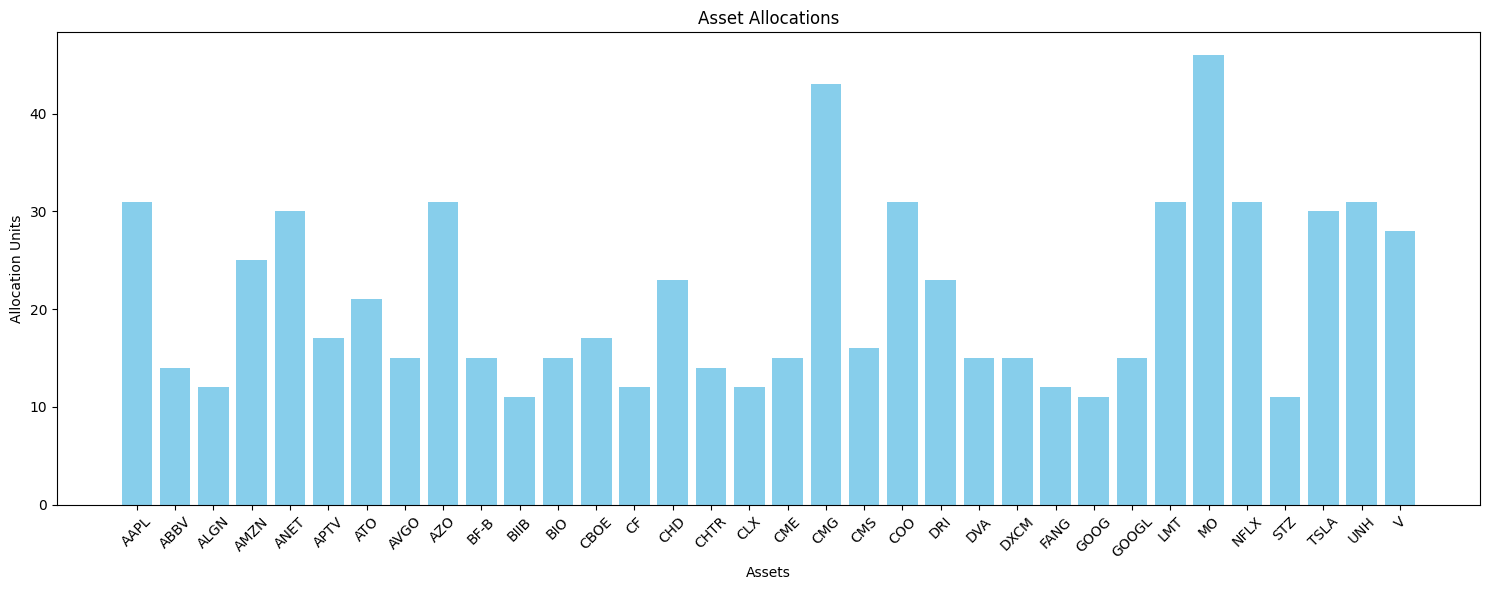

In [57]:
column_names = df.columns.tolist()

# Filter the weights and corresponding names for weights > 0
filtered_weights = [x for x in x_optimized if x > 10.0]
filtered_names = [column_names[i] for i, x in enumerate(x_optimized) if x > 10.0]
# Plotting the bar chart
plt.figure(figsize=(15, 6)) 
plt.bar(filtered_names, filtered_weights, color='skyblue') 
plt.xlabel('Assets')  # Adding x-label
plt.ylabel('Allocation Units')  # Adding y-label
plt.title('Asset Allocations')  # Adding title
plt.xticks(rotation=45)  # Rotating the x-axis labels for better readability if names are long
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

Creating the correlation heatmap

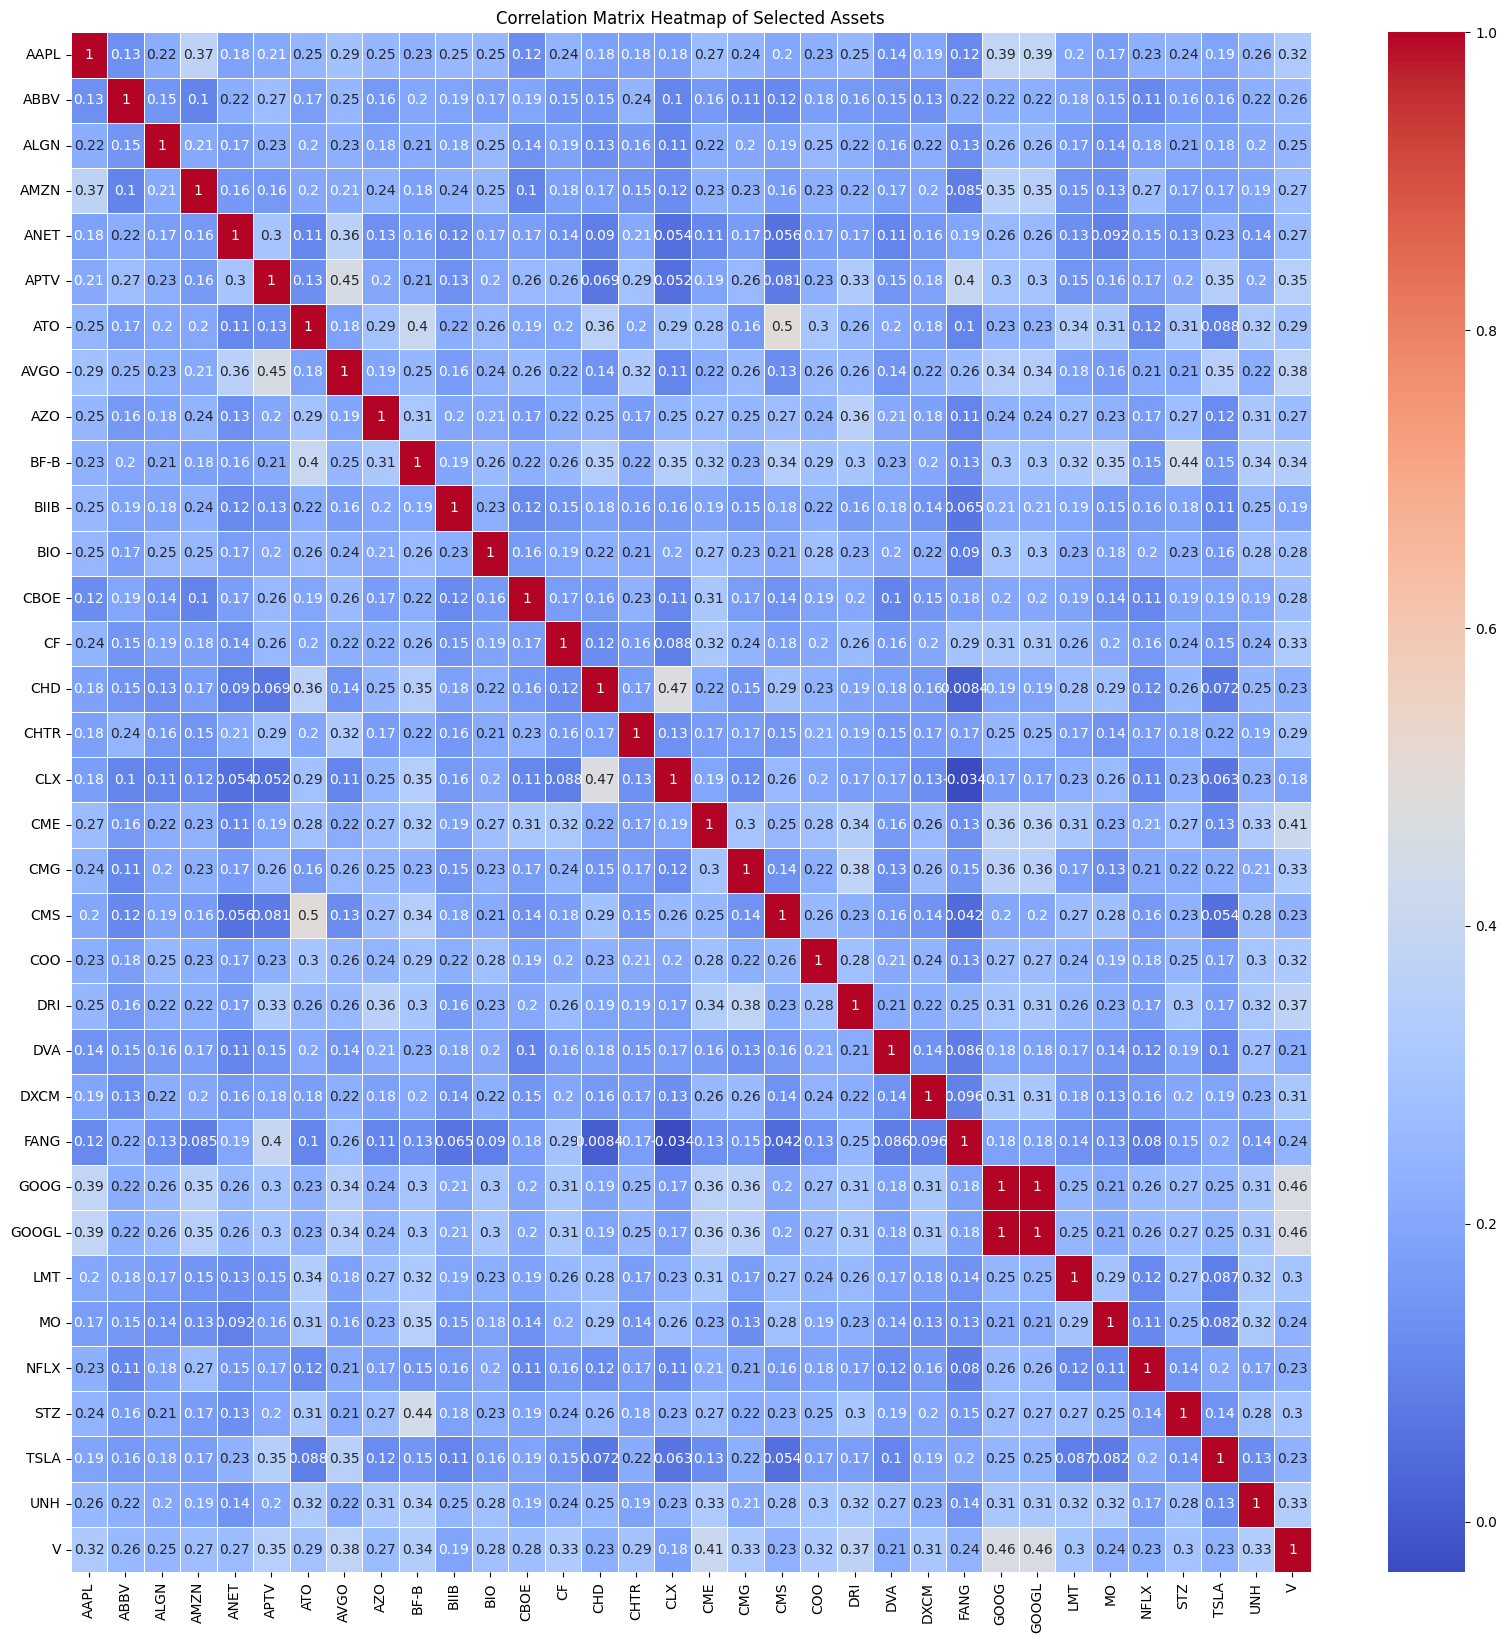

In [58]:
# Filter columns in df where the corresponding weight in w_min is greater than 0
filtered_df = df[filtered_names]

# Compute the correlation matrix
corr_matrix = filtered_df.corr()

# Plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix Heatmap of Selected Assets')
plt.show()


Now let us create a dataframe of results

In [60]:
# Append the values to the DataFrame
new_row = pd.DataFrame({'return': [total], 'risk': [risk_value]})

#Save the dataframe
new_row.to_excel("Quantum_Results.xlsx",index=False)

Creating the updated efficient frontier

Text(0.5, 1.0, 'Efficient Frontier')

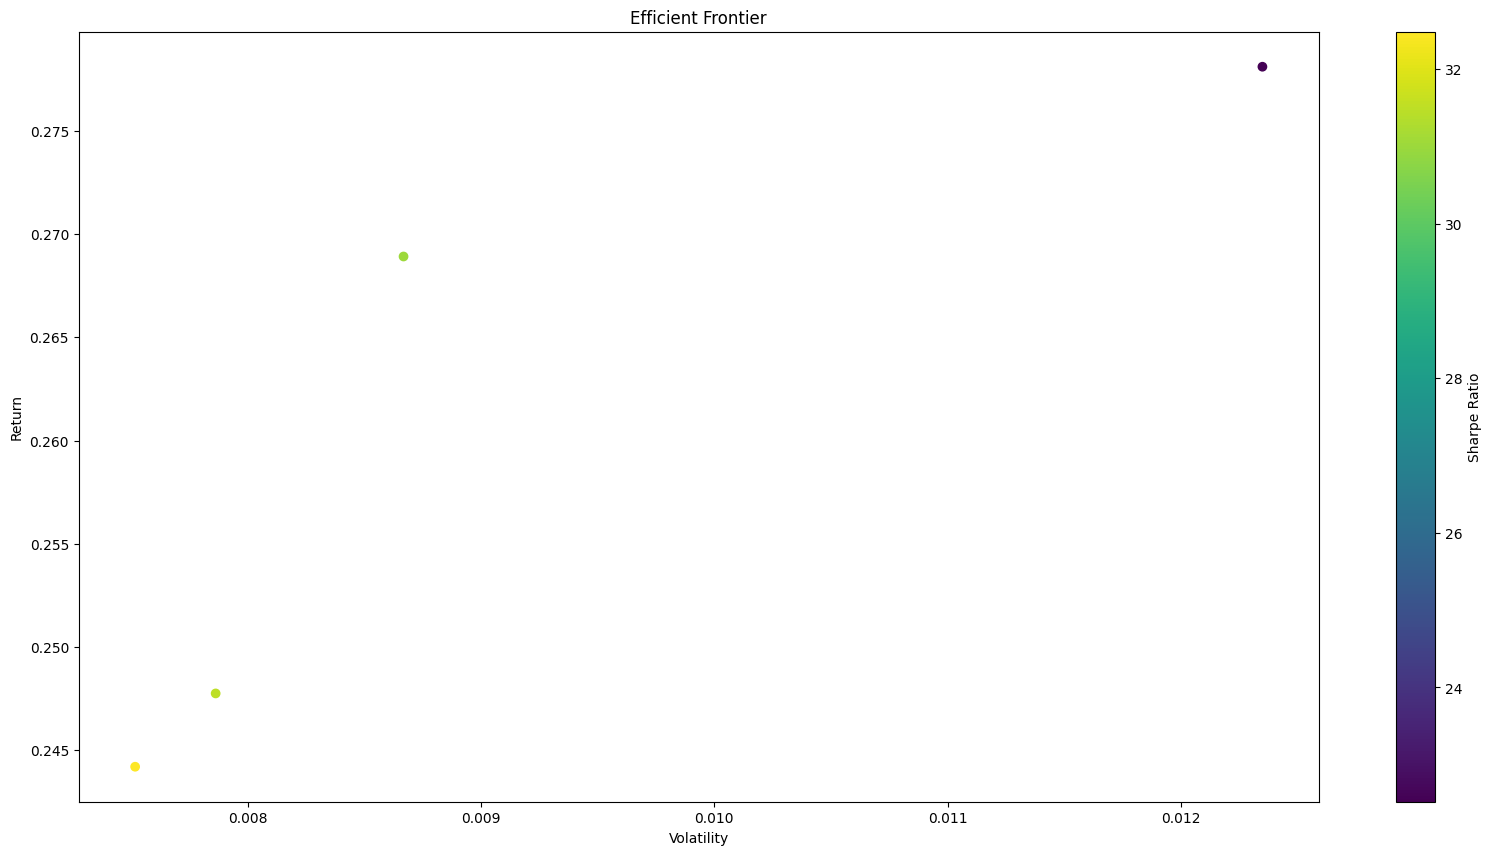

In [69]:


# Step 1: Reformulate the DataFrame
df_reformulated = final_results_df.groupby('total_return').agg(min_risk=('R', 'min')).reset_index()

# Step 2: Calculate the Sharpe Ratio
df_reformulated['Sharpe_Ratio'] = df_reformulated['total_return'] / df_reformulated['min_risk']

# Sort values for smooth curve plotting
df_reformulated.sort_values('min_risk', inplace=True)

# Step 3: Plotting the Efficient Frontier
plt.figure(figsize=(20, 10))

# Scatter plot
plt.scatter(df_reformulated["min_risk"], df_reformulated["total_return"], c=df_reformulated["Sharpe_Ratio"], cmap='viridis')

# Adding a colorbar
plt.colorbar(label='Sharpe Ratio')

# Labels and title
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')

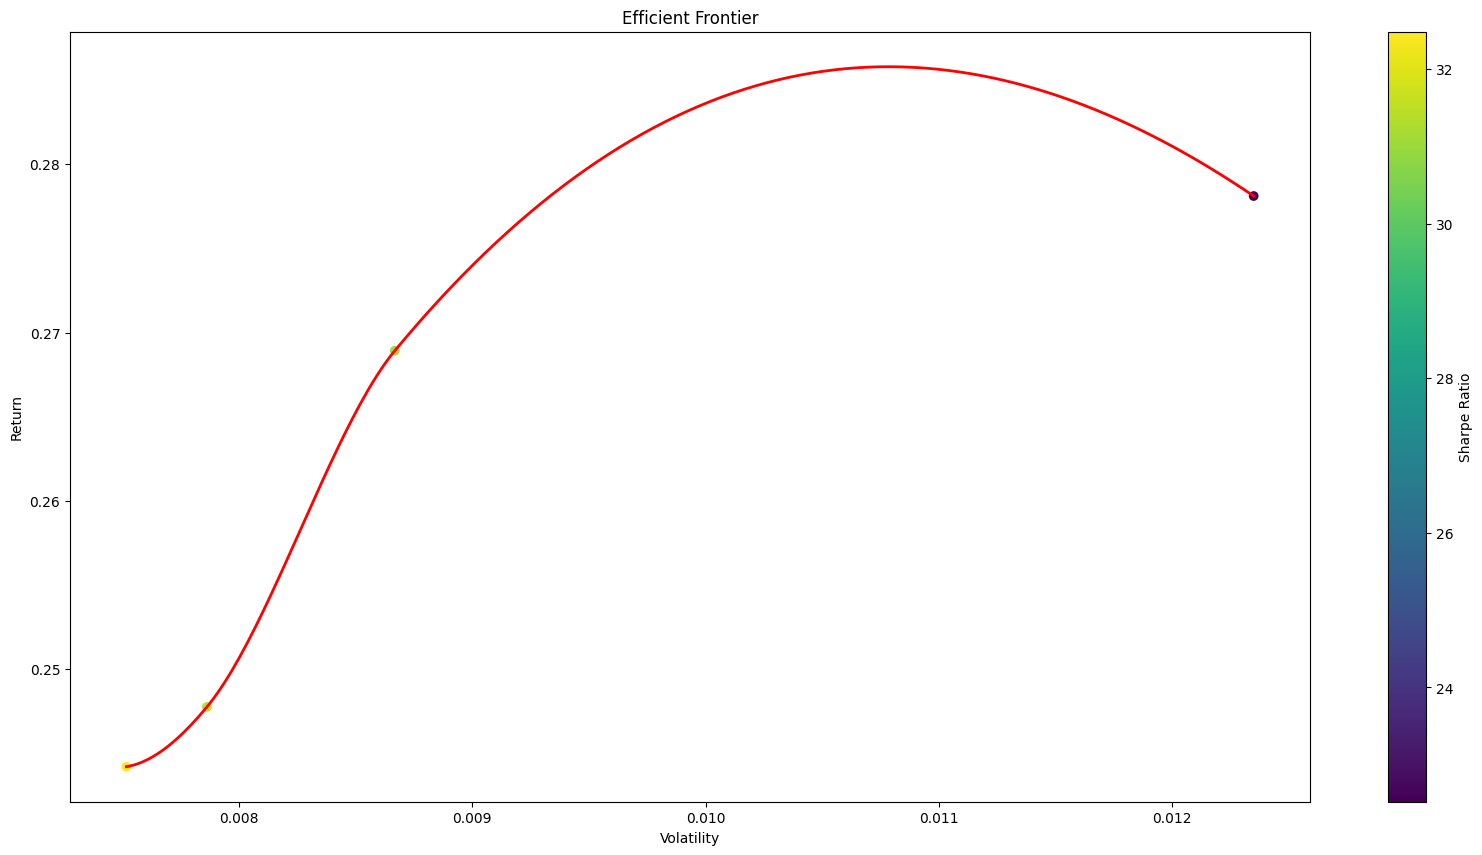

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Akima1DInterpolator

# Assuming you already have 'df_reformulated' ready from previous steps

# Create the Akima interpolator
akima_interpolator = Akima1DInterpolator(df_reformulated['min_risk'], df_reformulated['total_return'])

# Generate more x values for a smooth curve
x_fine = np.linspace(df_reformulated['min_risk'].min(), df_reformulated['min_risk'].max(), 300)

# Evaluate the interpolator to get y values
y_fine = akima_interpolator(x_fine)

plt.figure(figsize=(20, 10))

# Scatter plot of the original data points
plt.scatter(df_reformulated["min_risk"], df_reformulated["total_return"], c=df_reformulated["Sharpe_Ratio"], cmap='viridis')

# Plot the smooth curve
plt.plot(x_fine, y_fine, 'r-', linewidth=2)  # 'r-' denotes the color red with a solid line

# Adding a colorbar
plt.colorbar(label='Sharpe Ratio')

# Labels and title
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.show()
